In [1]:
from typing import Dict, Tuple, List


from pathlib import Path

import pandas as pd
import shap
import yaml

from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


pd.set_option('display.max_columns', None)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
path_root = '/home/yoshraf/projects/project-bruna/'
path_raw = 'data/raw'

PathRaw = Path(path_root + path_raw)
PathRoot = Path(path_root)

In [3]:
# Read YAML file
with open(PathRoot / "config.yaml", 'r') as stream:
    config = yaml.safe_load(stream)

In [4]:
df_md = pd.read_csv(PathRaw / 'bd_2017_fund_limpo.csv', index_col=0)
df_fd = pd.read_csv(PathRaw / 'bd_2017_medio_limpo.csv', index_col=0)
df_all = pd.read_csv(PathRaw / 'bd_2017_tds_limpo.csv', index_col=0)
df_sc = pd.concat([df_md, df_fd])

### Prep

In [5]:
def data_info(dataset: pd.DataFrame) -> pd.DataFrame:
    info = pd.DataFrame()
    info["var"] = dataset.columns
    info["# missing"] = list(dataset.isnull().sum())
    info["% missing"] = info["# missing"] / dataset.shape[0] * 100
    info["types"] = list(dataset.dtypes)
    info["unique values"] = list(
        len(dataset[var].unique()) for var in dataset.columns)
    return info

def encoder_onehot(dataset: pd.DataFrame, cat: List) -> pd.DataFrame:
    l_else = list(set(dataset.columns) -set(dataset[cat].columns))
    # OneHotCoding
    enc = OneHotEncoder(handle_unknown="error", drop="if_binary")
    X_cat = pd.DataFrame(enc.fit_transform(
        dataset[cat]).toarray(), columns=enc.get_feature_names_out(cat))
    dataset[l_else]
    X = pd.concat([dataset[l_else].reset_index(), X_cat], axis=1).set_index('index')
    return X

In [6]:
cat = config['features']['category']
num = config['features']['numeric']

In [7]:
X = df_sc[list(set(cat + num) & set(df_sc.columns))]
# map
X['tipo'] = X['tipo'].map({'Publica': 0, 'Privada': 1})
X = encoder_onehot(X, cat)
# missing
X = X.fillna(X.mean())
y = df_sc[config['label']]
y = y.TIPVG - 1 
print(data_info(X)['% missing'].max())
X.head()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

0.0



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Modeling

              precision    recall  f1-score   support

    Coletivo       0.81      0.64      0.71       869
  Individual       0.72      0.64      0.68       528
        A pé       0.76      0.91      0.83      1297
   Bicicleta       0.00      0.00      0.00         6

    accuracy                           0.77      2700
   macro avg       0.57      0.55      0.56      2700
weighted avg       0.77      0.77      0.76      2700



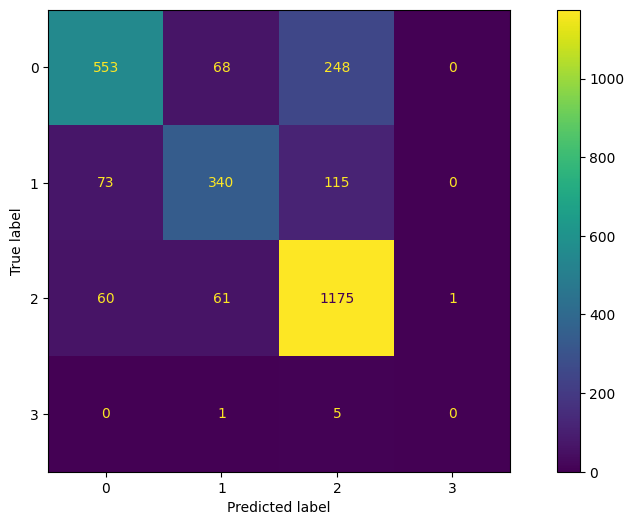

In [8]:
def modeling(estimator, X_train, X_test, y_train, y_test, params, map_class):
    # Fit and Training model
    model = estimator(**params)
    model.fit(X_train, y_train)
    # Predict test and train datasets
    y_pred_test = model.predict(X_test)
    # Plot Confusion Matrix
    _, ax = plt.subplots(1, figsize=(12, 6))
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, ax=ax)
    labels = map_class.keys()
    # Classification Report
    print(classification_report(y_test, y_pred_test, target_names=labels))
    return model

params = {'max_depth': 9, 'random_state': 42}
map_class = {0: 'Coletivo', 1: 'Individual', 2: 'A pé', 3: 'Bicicleta'}
map_class_2 = {'Coletivo': 0, 'Individual': 1, 'A pé': 2, 'Bicicleta': 3}

rf_model = modeling(RandomForestClassifier, X_train, X_test, y_train, y_test,  params, map_class_2)

### SHAP

In [9]:
def create_tree_shap(X, tree):
    explainer_tree = shap.Explainer(tree)
    return explainer_tree(X)

shap_values = create_tree_shap(X_test, rf_model)

### Feature Importance

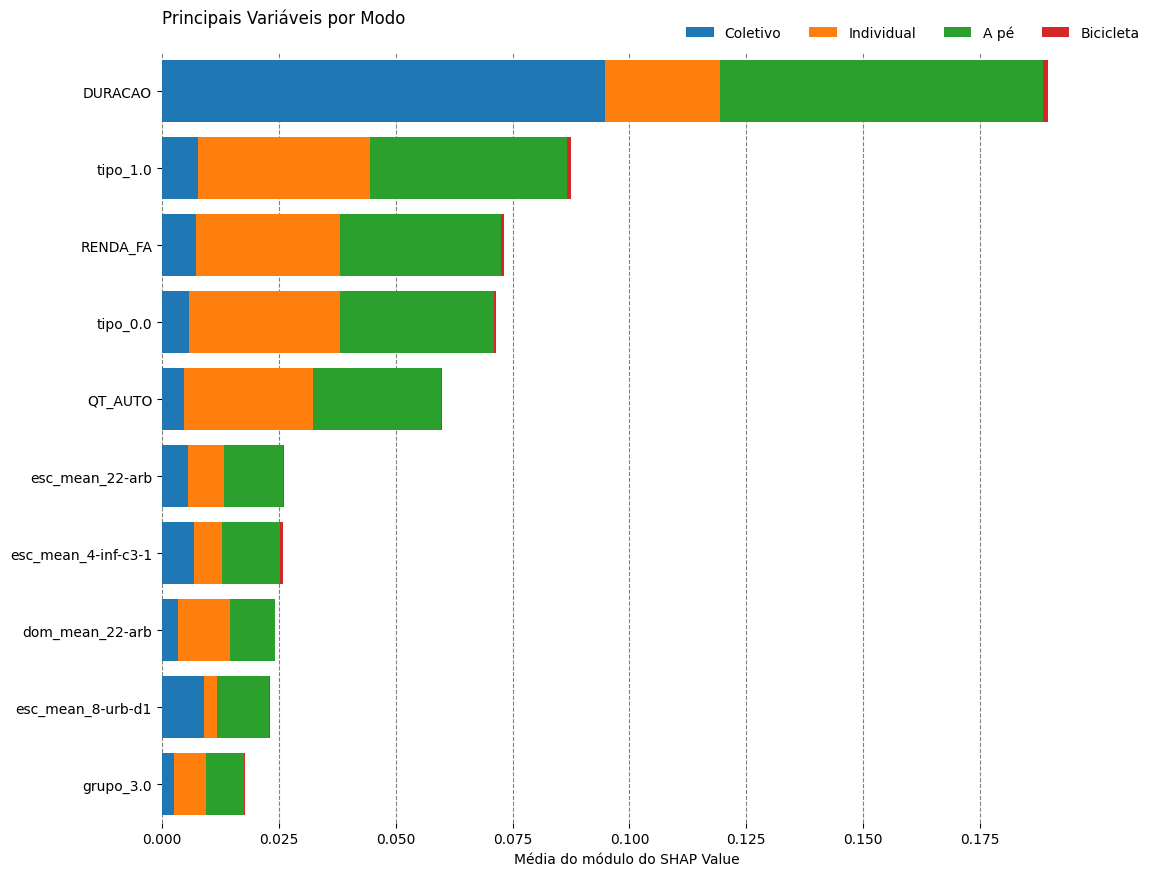

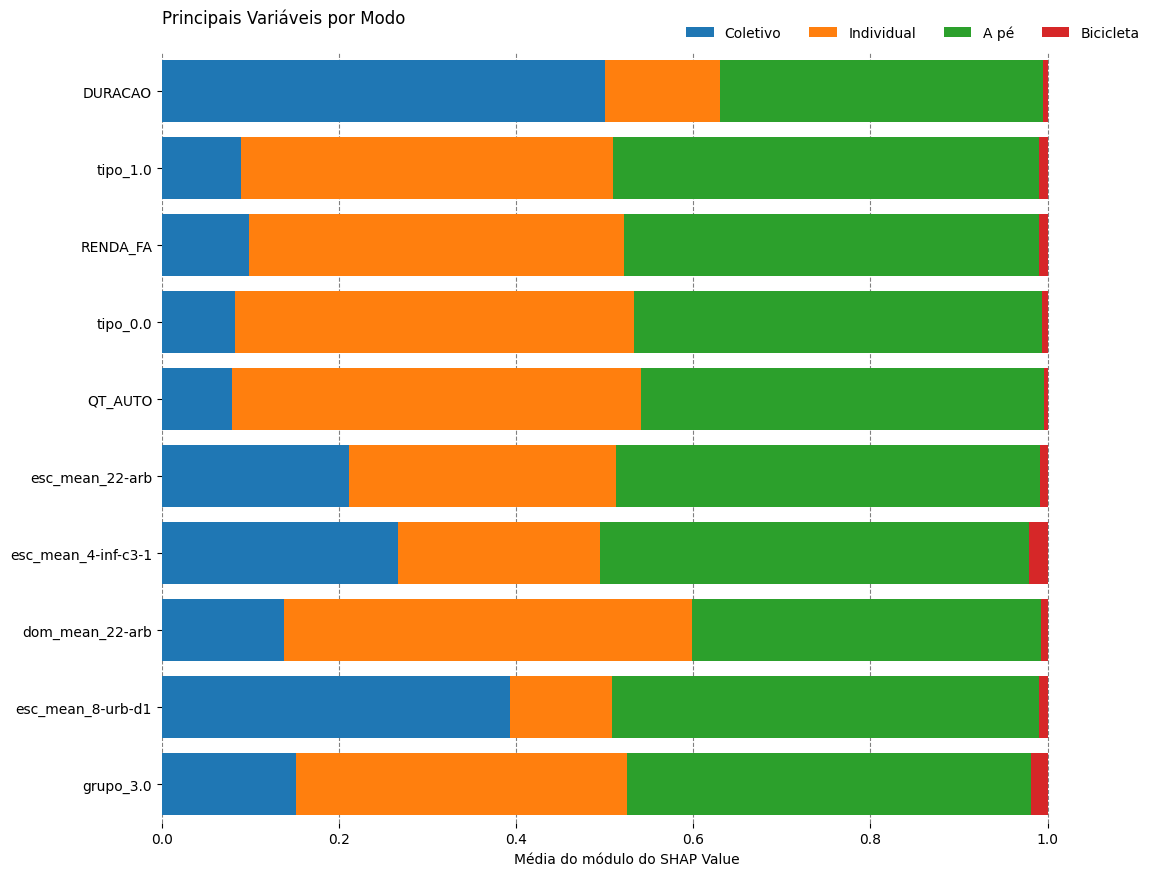

In [10]:
def return_main_features(shap_v, y_class):
    dict_important = {}
    for fe in shap_v.feature_names:
        dict_important[fe] = abs(shap_v[:, fe, y_class].values).mean()
    df = pd.DataFrame(
        dict_important.items(), columns=['features', 'shap_values']
    ).sort_values(by='shap_values', ascending=False)
    return df


def return_df_barplot(shap_v, map_class, nfeatures=10):
    df = pd.concat(
        [return_main_features(shap_v, v).rename(
            columns={'features': 'features', 'shap_values': f'shap_values_{k}'}
        ) for k, v in map_class.items()], axis=1)
    # Drop duplicates columns
    df = df.loc[:, ~df.columns.duplicated()].copy()
    # Total
    df = df.assign(total=df.iloc[:, 1:].sum(axis=1))
    df = df.reset_index().drop(
        columns="index").set_index("features")
    return df.sort_values('total').tail(nfeatures)

def plot_main_features(df_barplot, map_class, normalize=None, save_plot=None):
    # Setting
    fields = list(df_barplot.columns)[:-1]
    # Create figure
    fig, ax = plt.subplots(1, figsize=(12, 10))
    # plot bars
    left = len(df_barplot) * [0]
    if normalize:
        for name in fields:
            plt.barh(df_barplot.index,
                     df_barplot[name] / df_barplot["total"], left=left)
            left = left + df_barplot[name] / df_barplot["total"]
    else:
        for name in fields:
            plt.barh(df_barplot.index, df_barplot[name], left=left)
            left = left + df_barplot[name]

    # Set title, legend, labels
    plt.title('Principais Variáveis por Modo\n', loc='left')
    plt.legend(map_class.keys(), bbox_to_anchor=(
        [0.55, 1, 0, 0]), ncol=4, frameon=False)
    plt.xlabel('Média do módulo do SHAP Value')
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    # Adjust limits and draw grid lines
    plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
    ax.set_axisbelow(True)
    ax.xaxis.grid(color='gray', linestyle='dashed')
    # Save plot
    if save_plot:
        PATH_FIG_FI = PATH_FIG + "shap_feature_importance/"
        if normalize:
            plt.savefig(
                PATH_FIG_FI + f"fi_normalize_{save_plot}",  dpi=fig.dpi, bbox_inches='tight')
        else:
            plt.savefig(PATH_FIG_FI + f"fi_{save_plot}",
                        dpi=fig.dpi, bbox_inches='tight')
    plt.show()

df_barplot = return_df_barplot(shap_values, map_class_2)
plot_main_features(df_barplot, map_class_2)

plot_main_features(df_barplot, map_class_2, True)

### Beeswarm

Coletivo


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


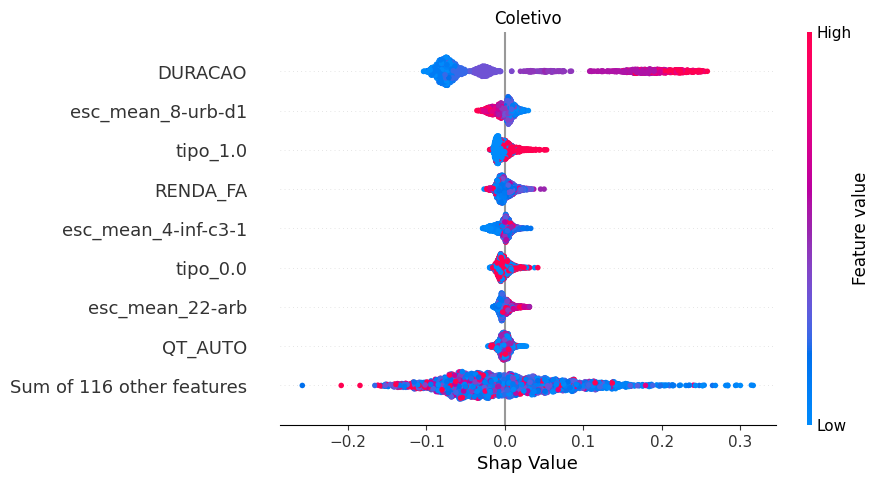

Individual


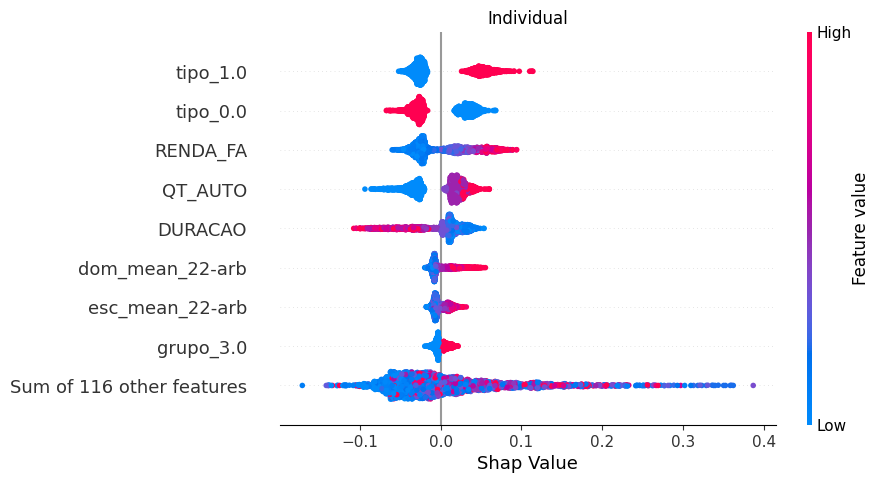

A pé


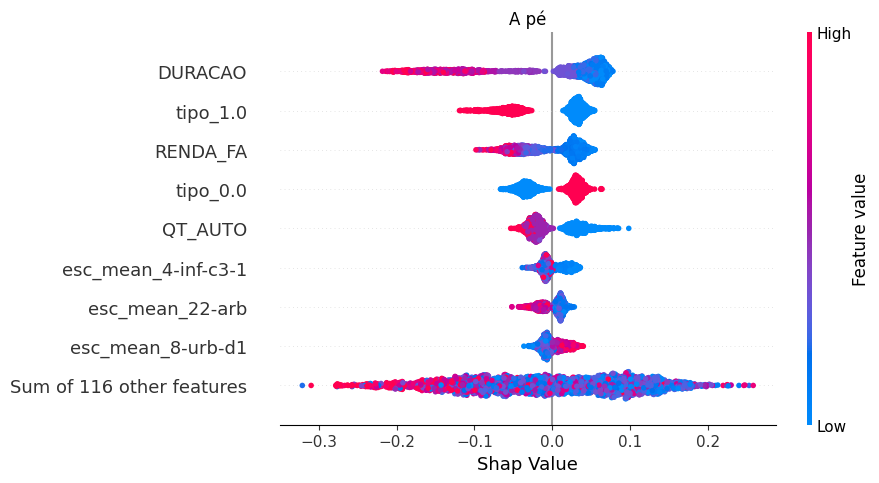

Bicicleta


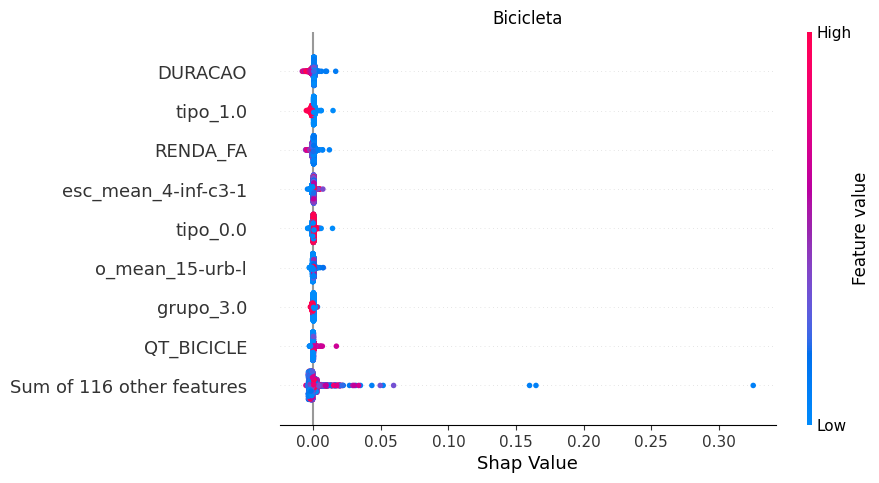

In [11]:
def plot_several_beeswarm(shap_v, map_class, save_plot=None):
    for mod, mod_id in map_class.items():
        print(mod)
        fig, ax = plt.subplots(1)
        shap.plots.beeswarm(shap_v[:, :, mod_id], max_display=9, show=False)
        ax.set_title(mod)
        ax.set_xlabel('Shap Value')
        # Save plot
        if save_plot:
            PATH_FIG_BEE = PATH_FIG + "shap_beeswarm/"
            mode_save = mod.replace('/','')
            plt.savefig(PATH_FIG_BEE +
                        f"bee_{mode_save}_{save_plot}",  dpi=fig.dpi, bbox_inches='tight')
        plt.show()

plot_several_beeswarm(shap_values, map_class_2)

### PDP

Coletivo


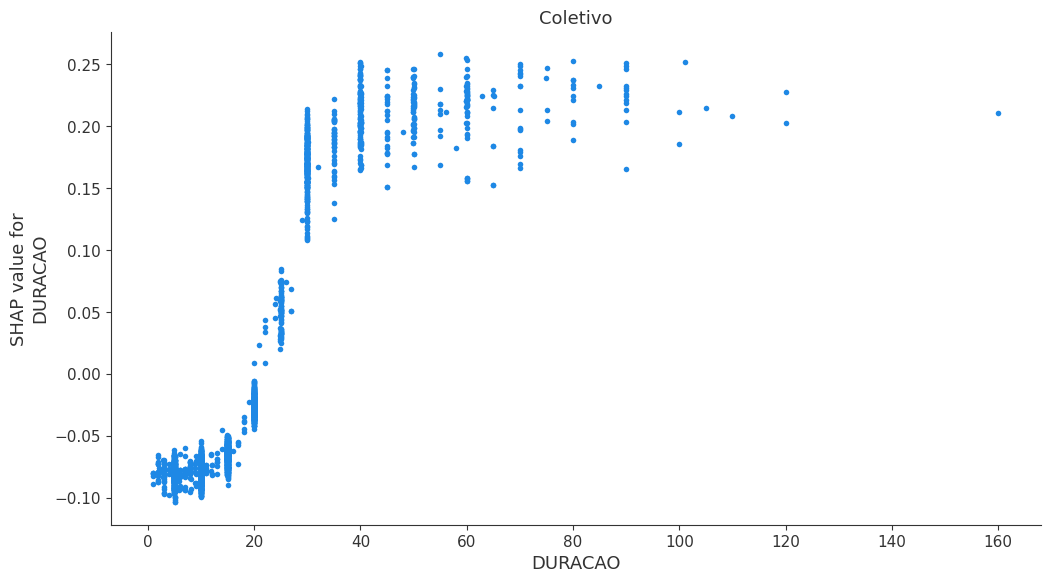

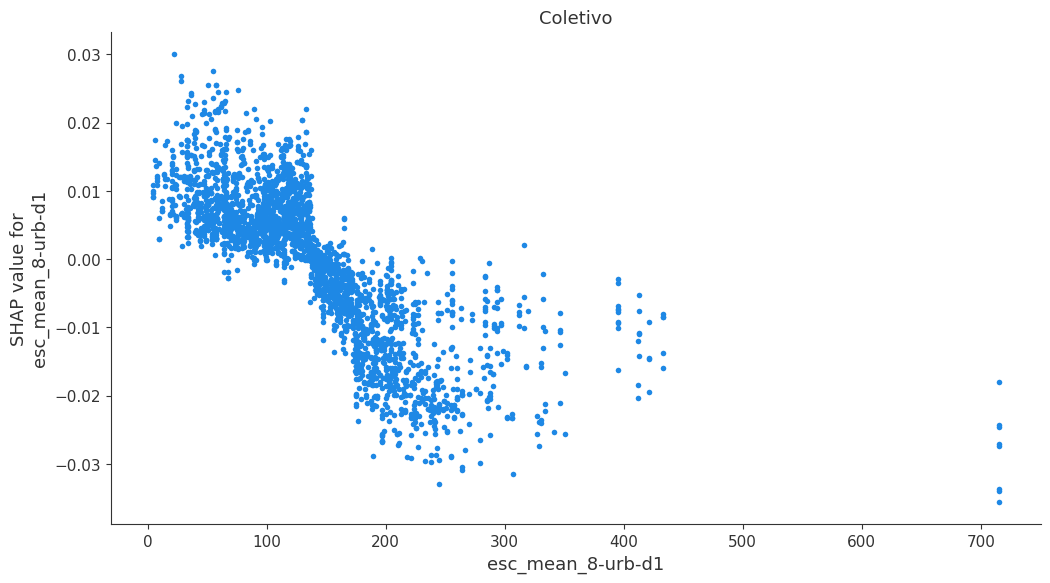

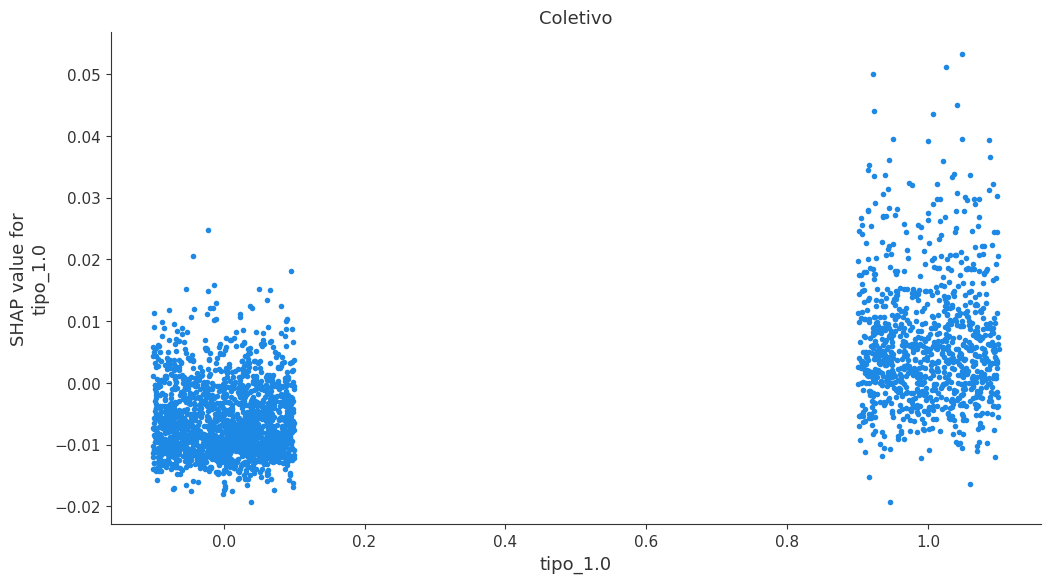

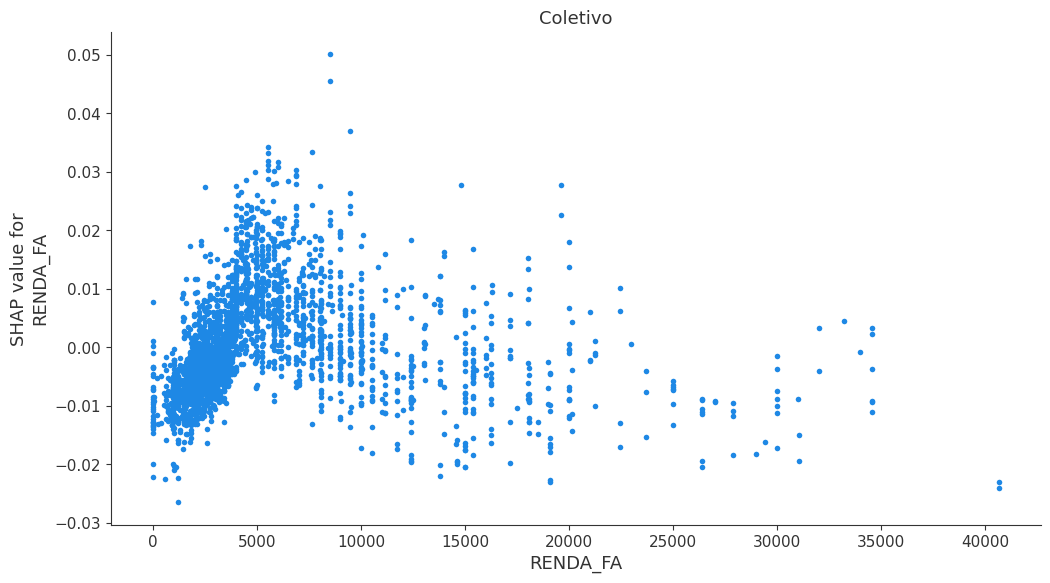

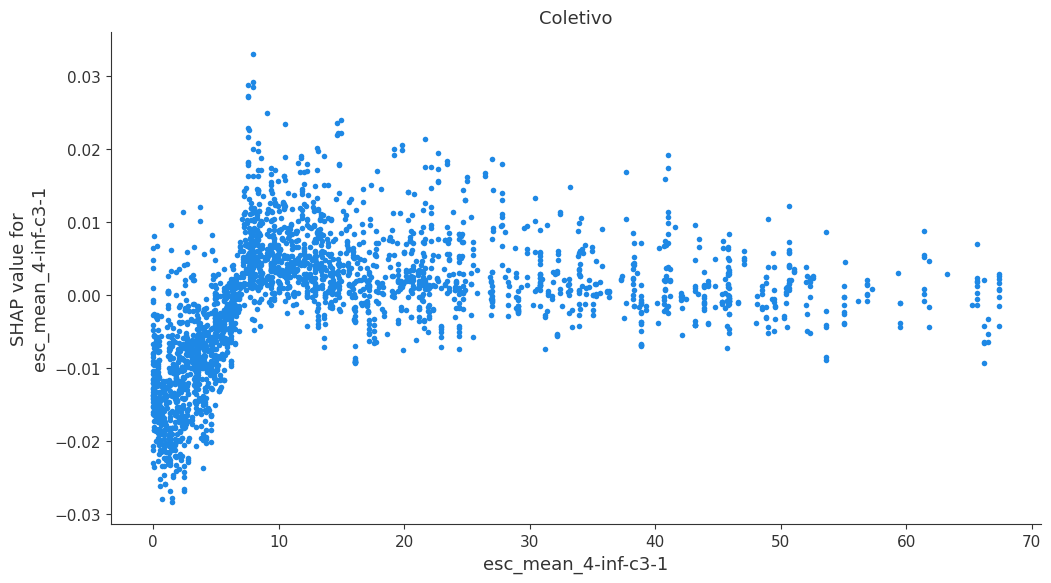

Individual


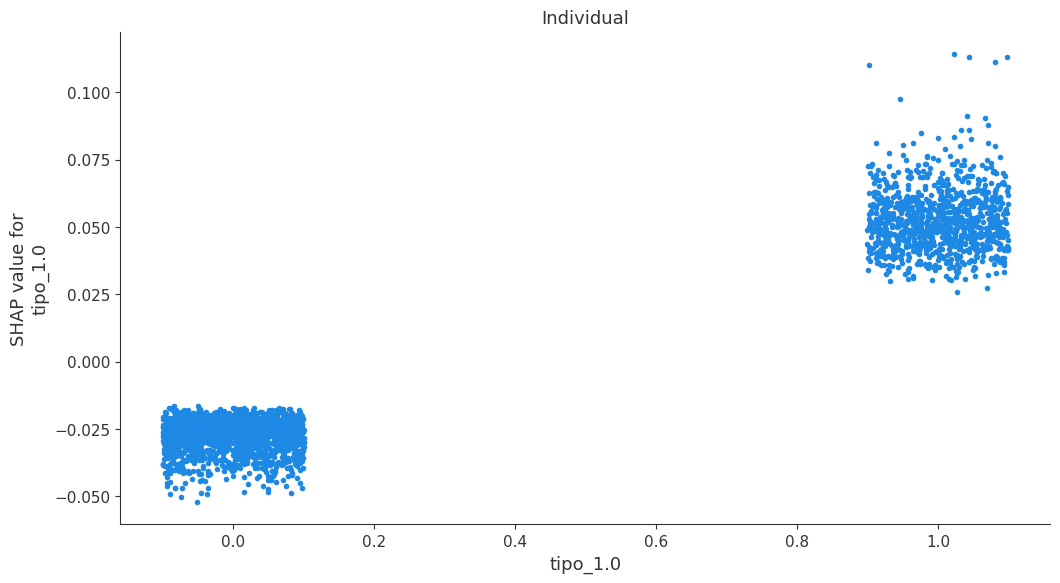

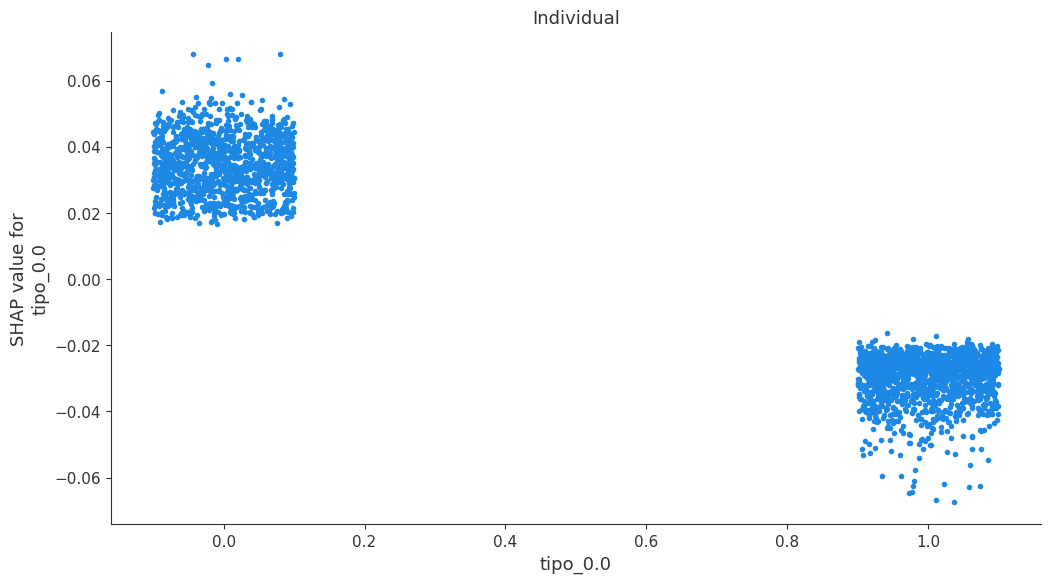

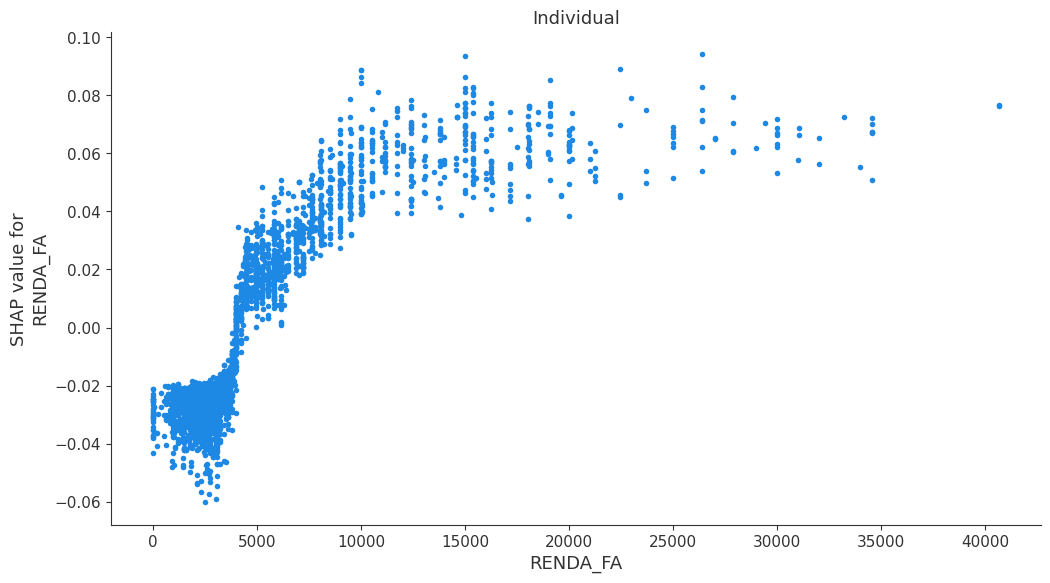

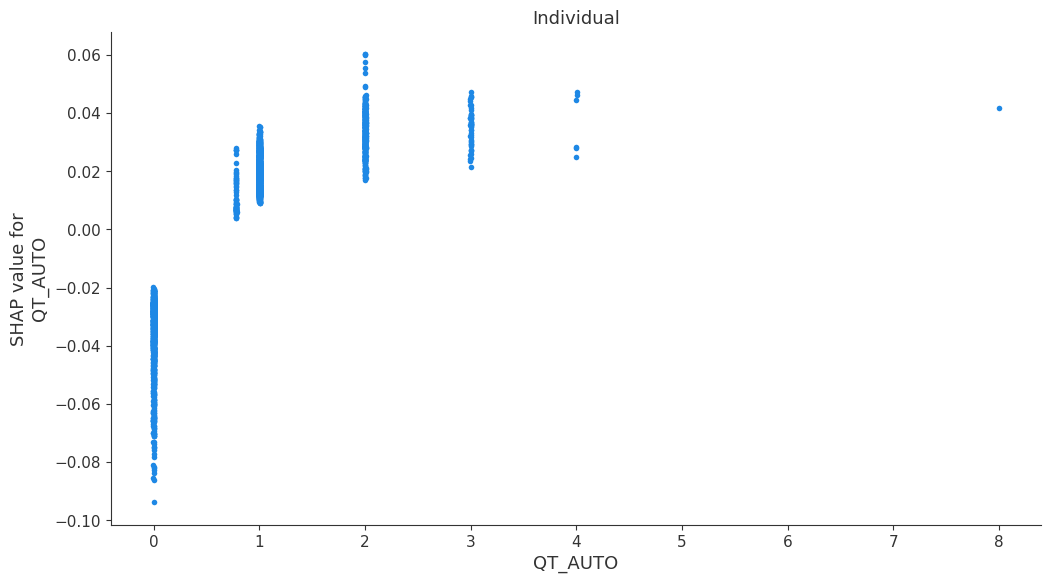

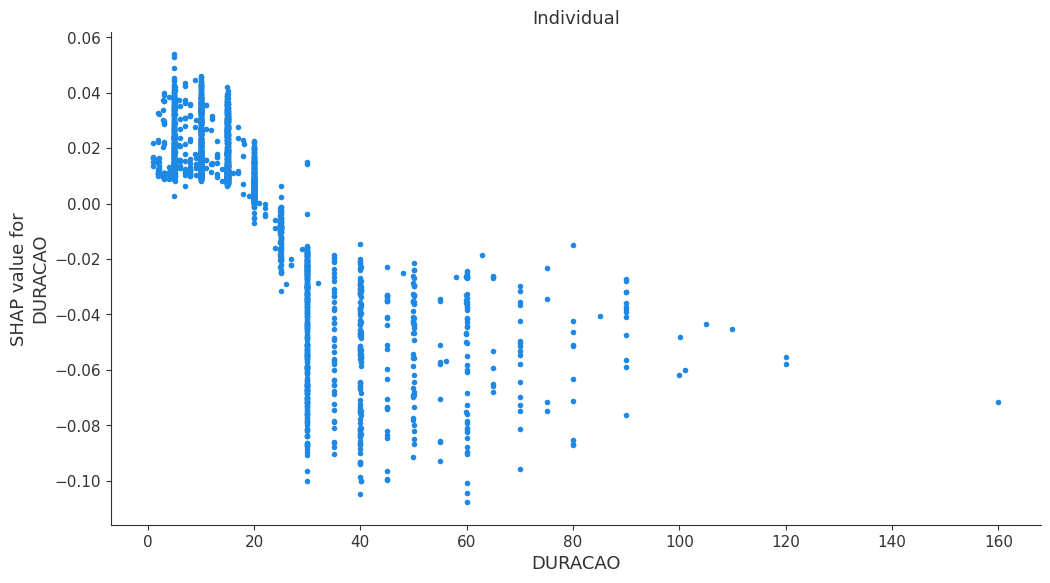

A pé


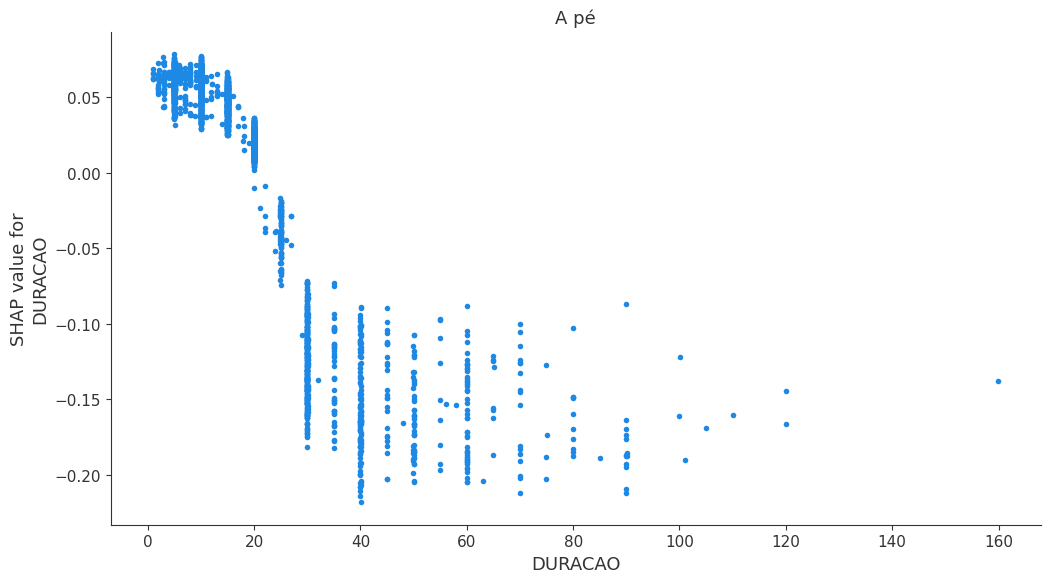

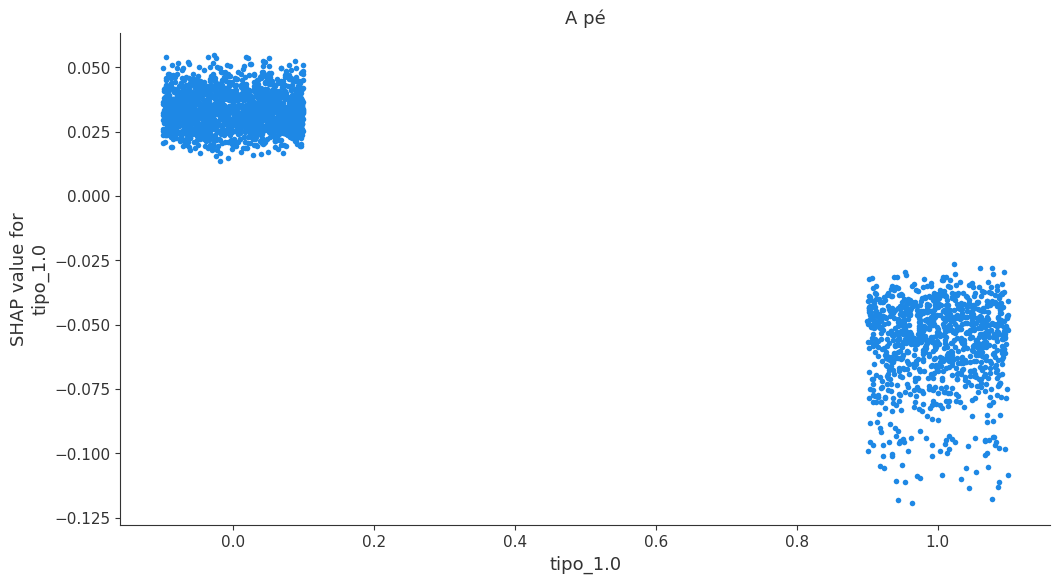

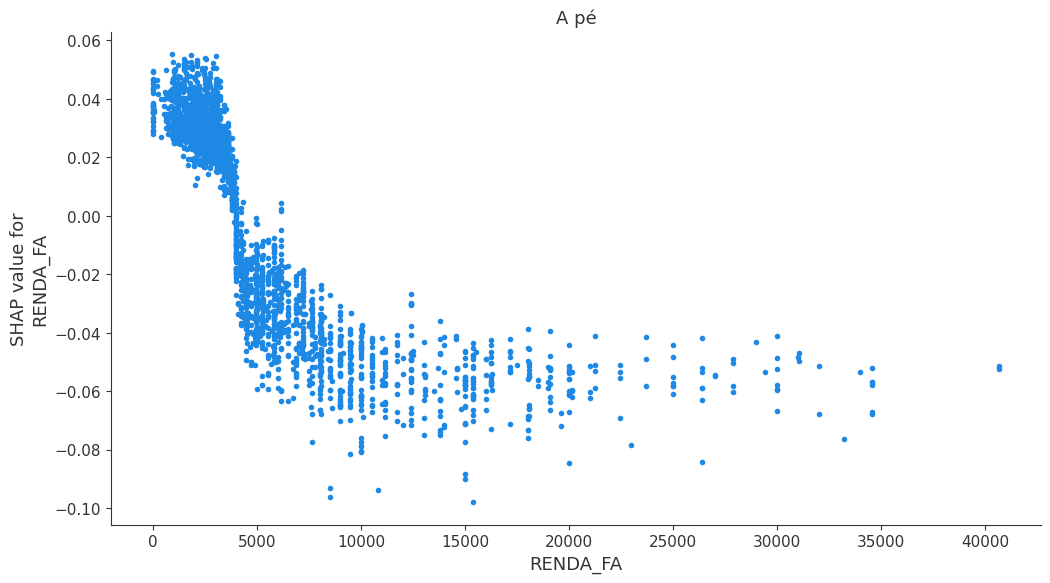

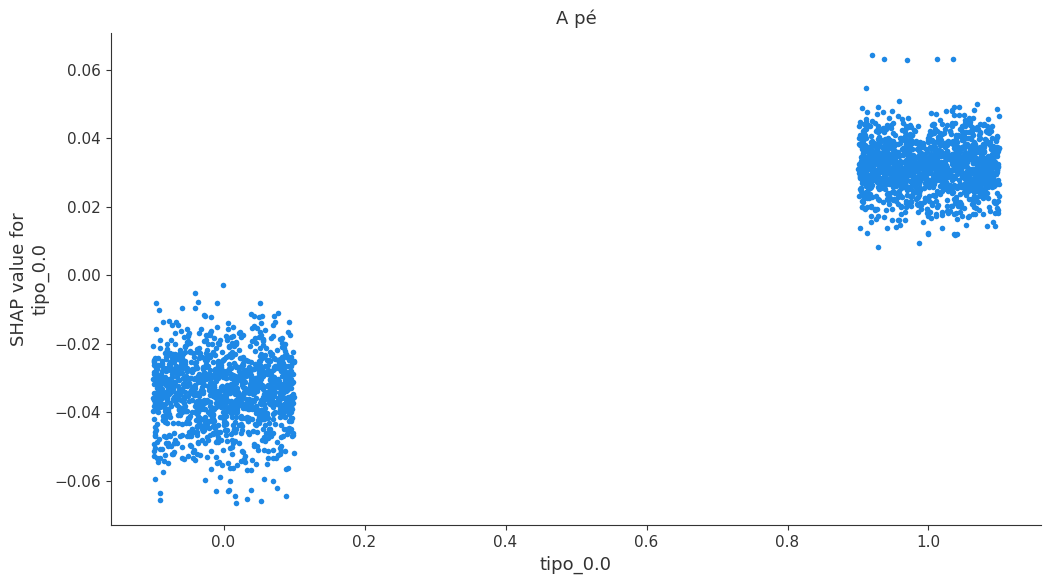

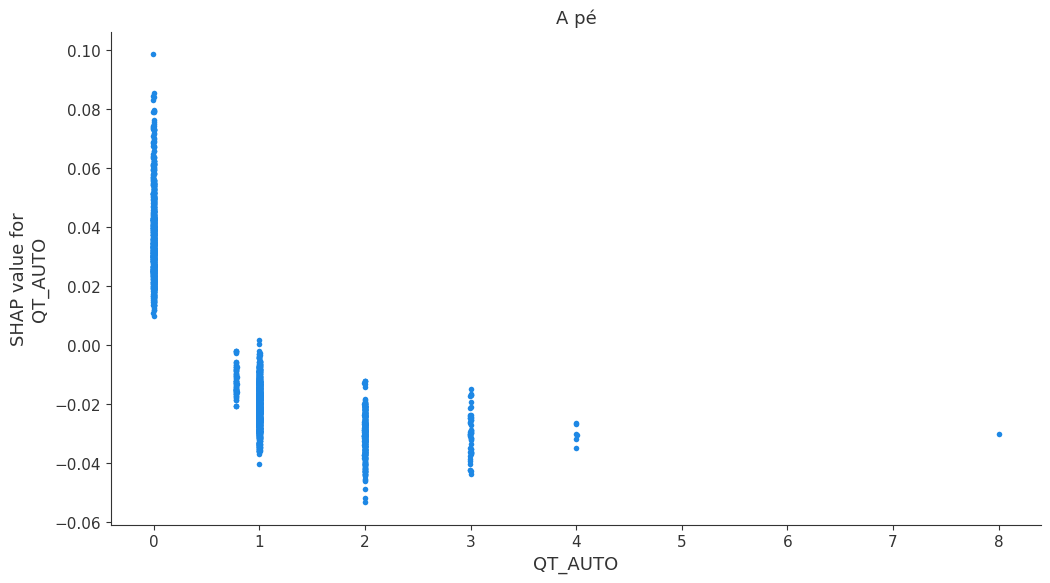

Bicicleta


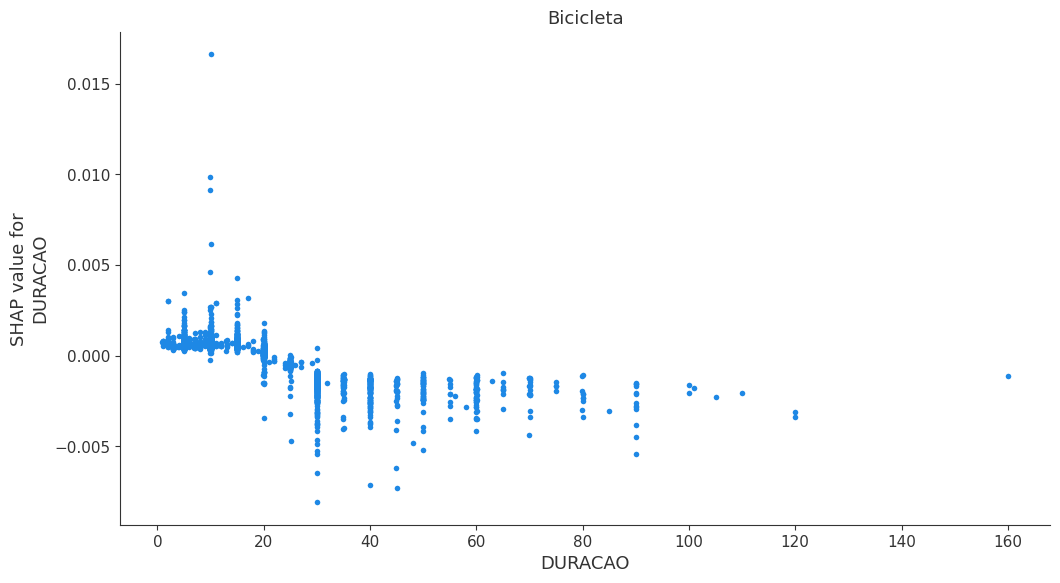

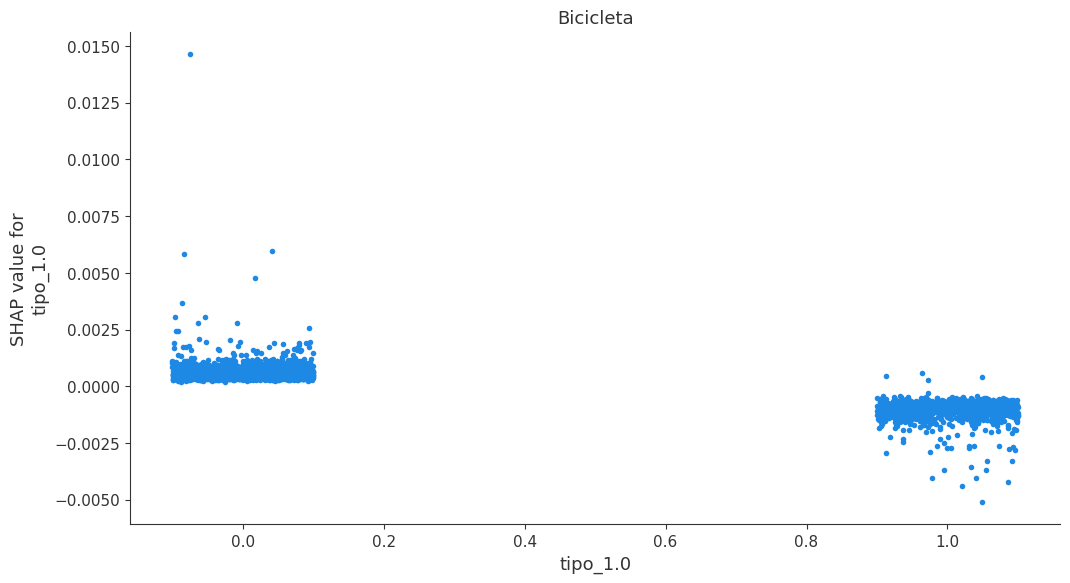

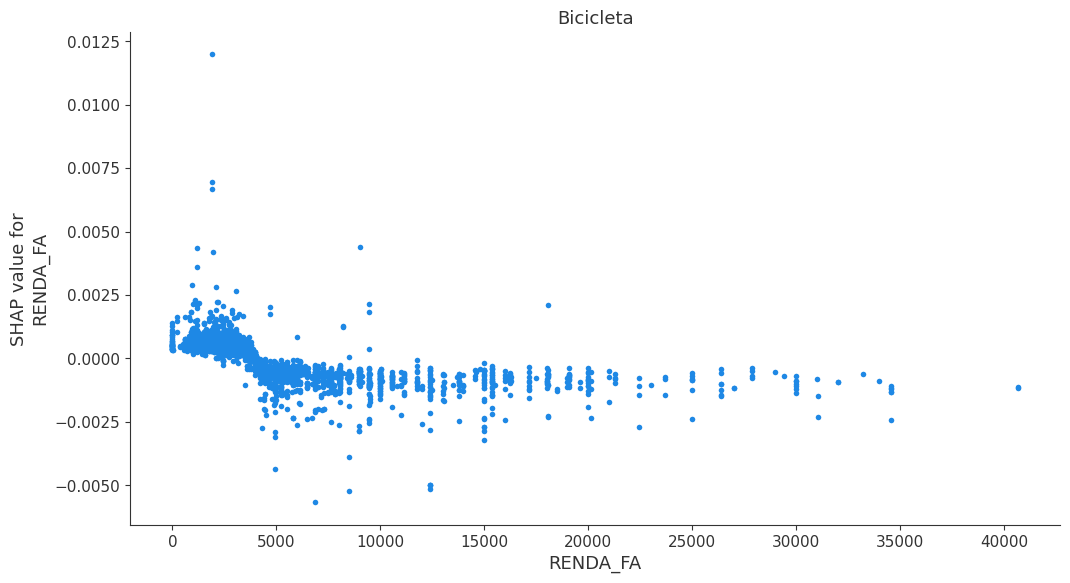

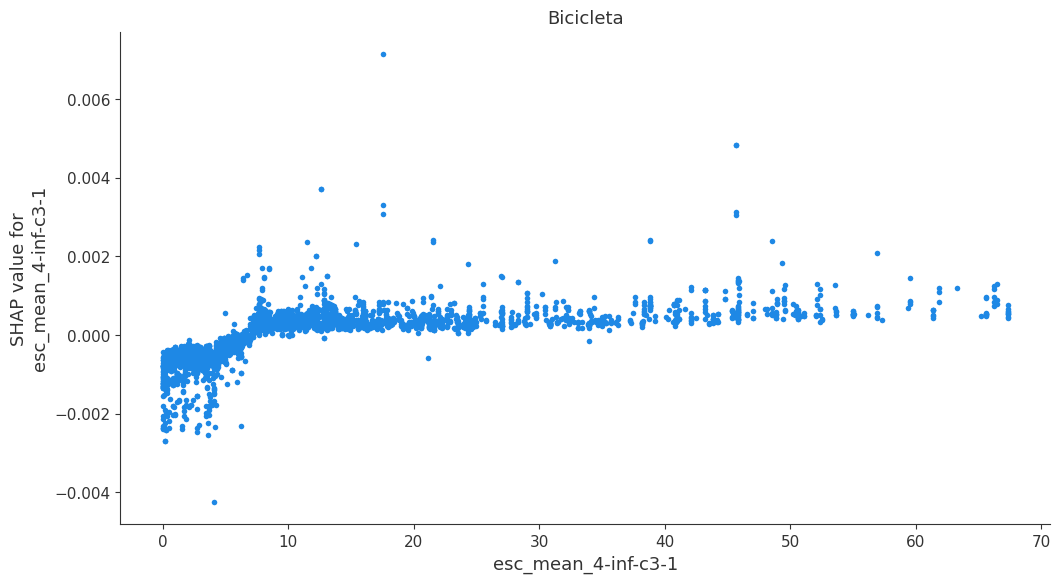

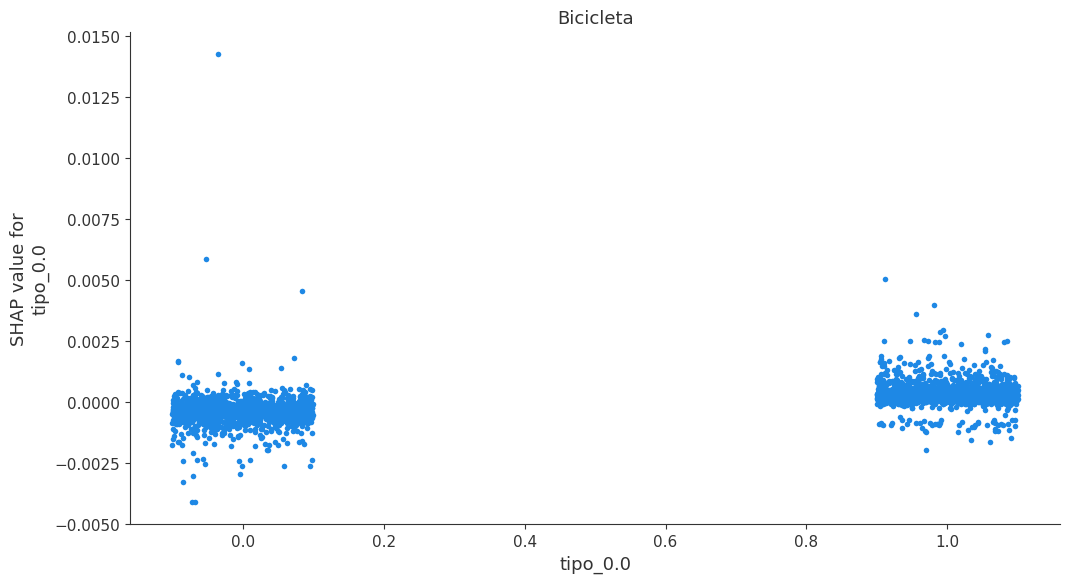

In [12]:
def get_main_features(df_bar, y_class, n=5):
    return (df_bar[f"shap_values_{y_class}"].sort_values(ascending=False) * 100)[:n].index


def plot_scatter(df_bar, shap_v, map_class, save_plot=None):
    for mode, mode_idx in map_class.items():
        print(mode)
        top5 = get_main_features(df_bar, mode)
        for c in top5:
            z = 0.8
            fig, ax = plt.subplots(1, figsize=(15 * z, 8 * z))
            shap.plots.scatter(shap_v[:, c, mode_idx], ax=ax, title=mode,
                               show=False, hist=False)
            if save_plot:
                PATH_FIG_SCT = PATH_FIG + "shap_scatter/"
                mode_save = mode.replace('/','')
                plt.savefig(PATH_FIG_SCT +
                            f"scatter_{mode_save}_{c}_{save_plot}",  dpi=fig.dpi, bbox_inches='tight')
            plt.show()


plot_scatter(df_barplot, shap_values, map_class_2)

### Variáveis Prioritárias

In [13]:
priority = config['features']['priority']

In [15]:
shap_values_p = shap_values[:,priority,:]

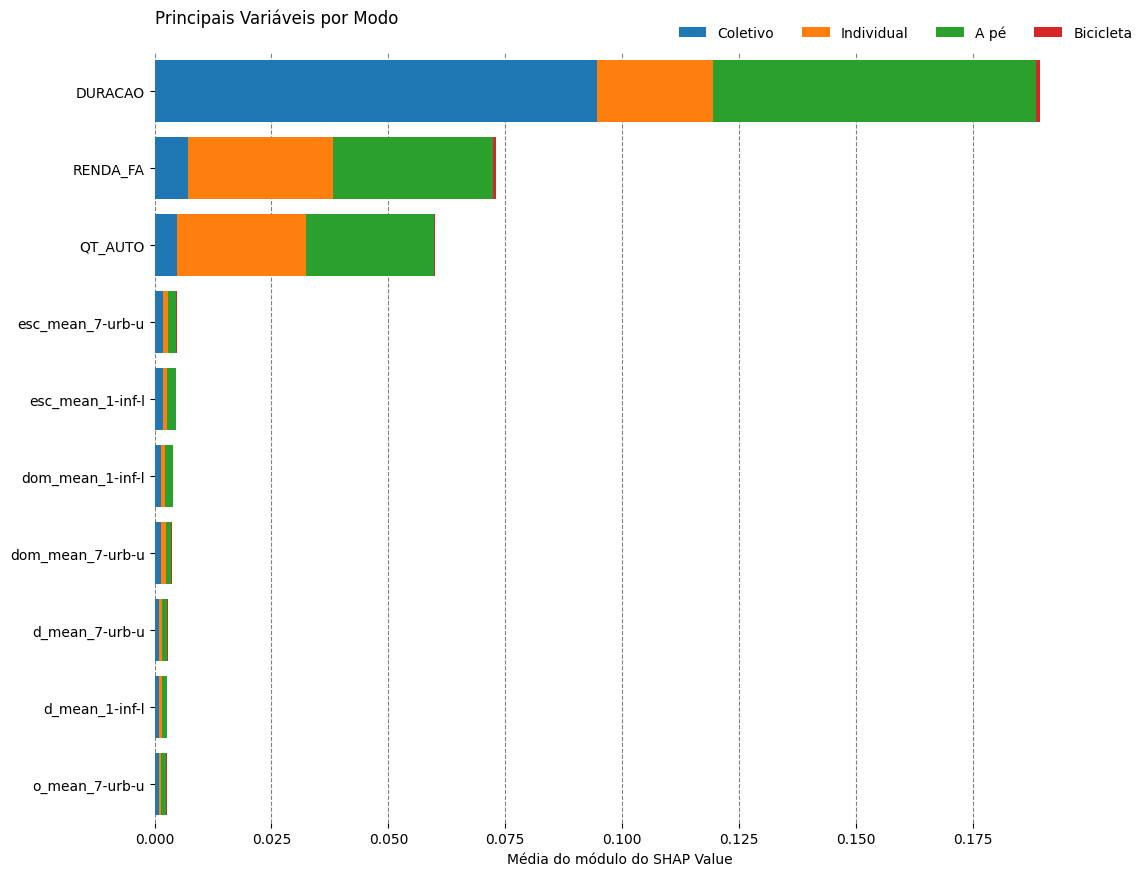

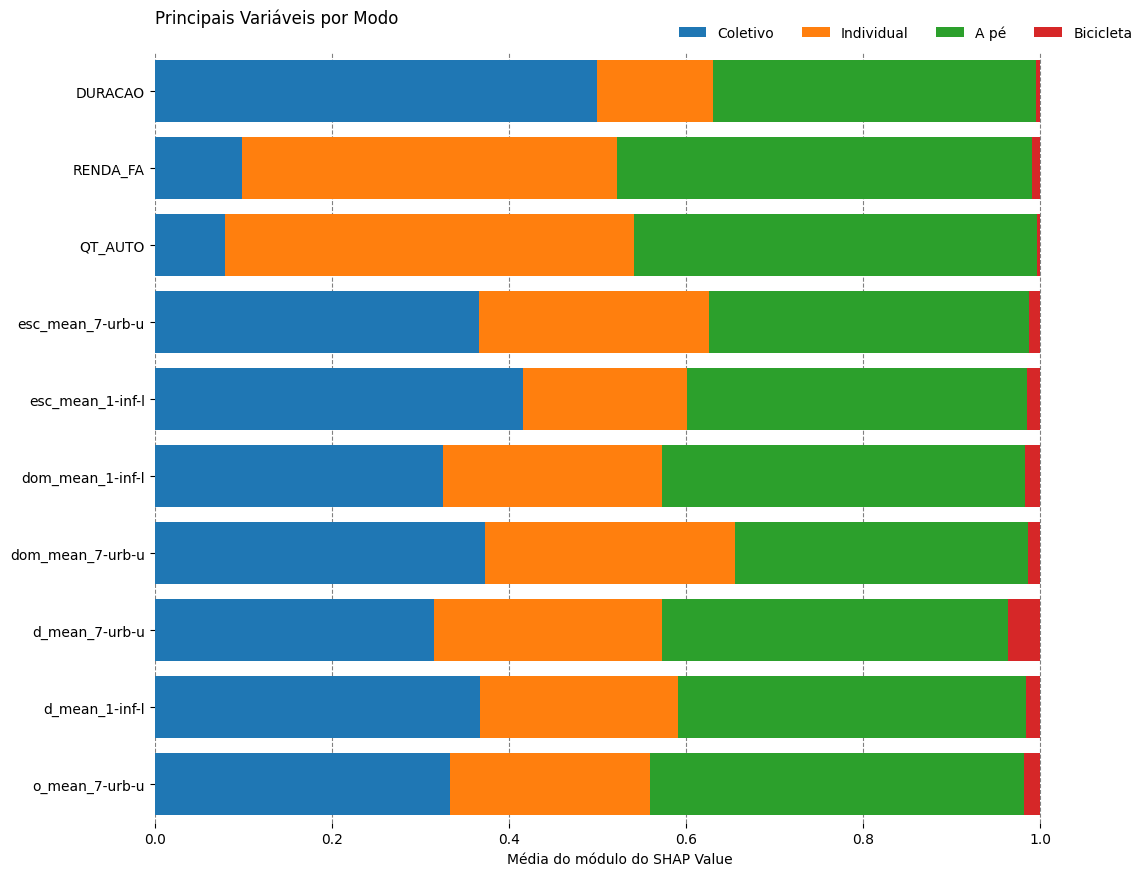

In [16]:
df_barplot = return_df_barplot(shap_values_p, map_class_2)
plot_main_features(df_barplot, map_class_2)

plot_main_features(df_barplot, map_class_2, True)

Coletivo


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


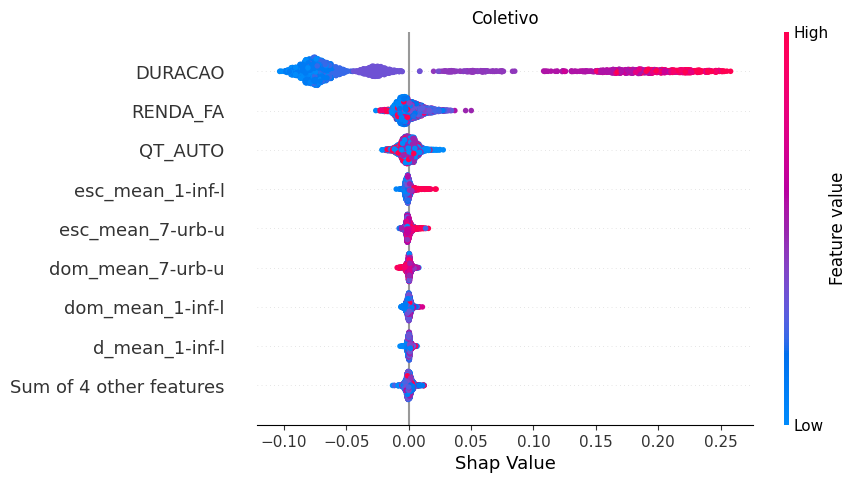

Individual


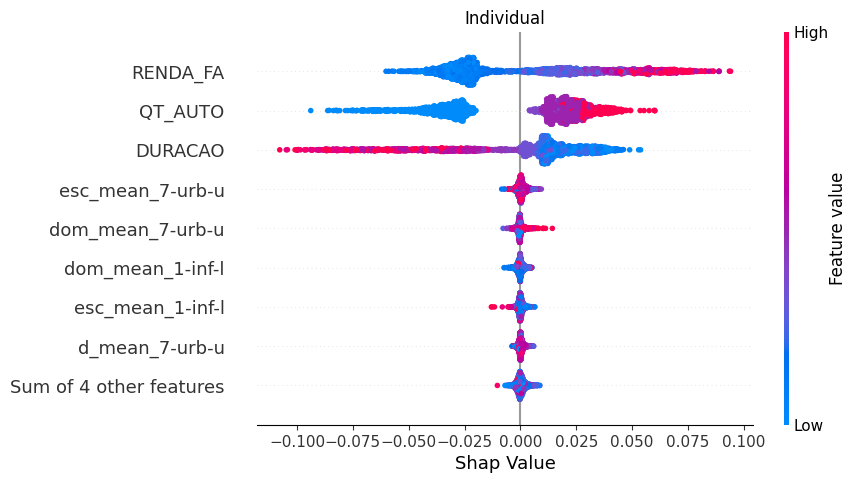

A pé


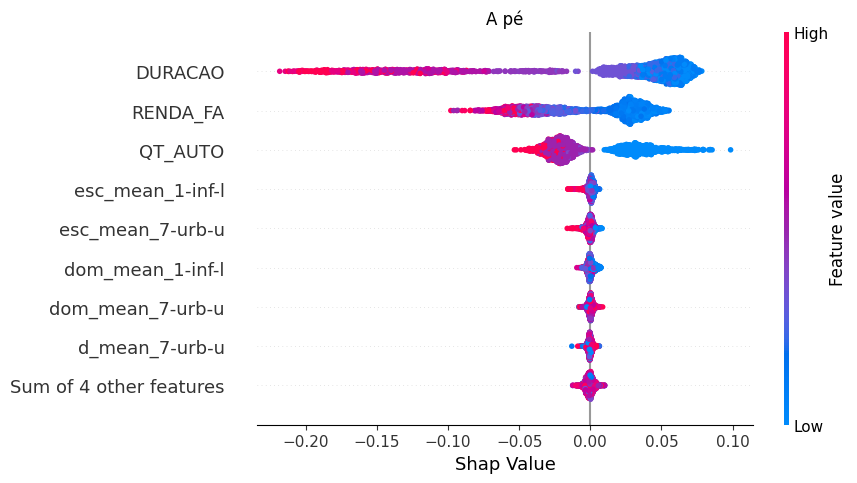

Bicicleta


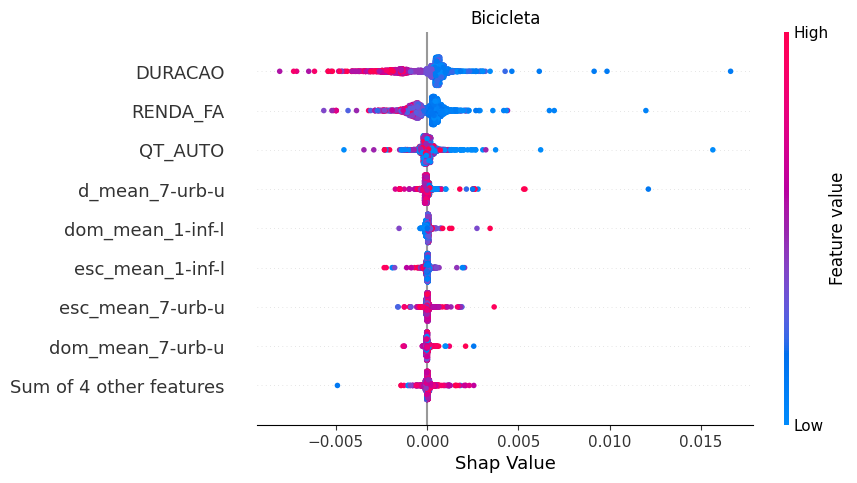

In [17]:
plot_several_beeswarm(shap_values_p, map_class_2)

Coletivo


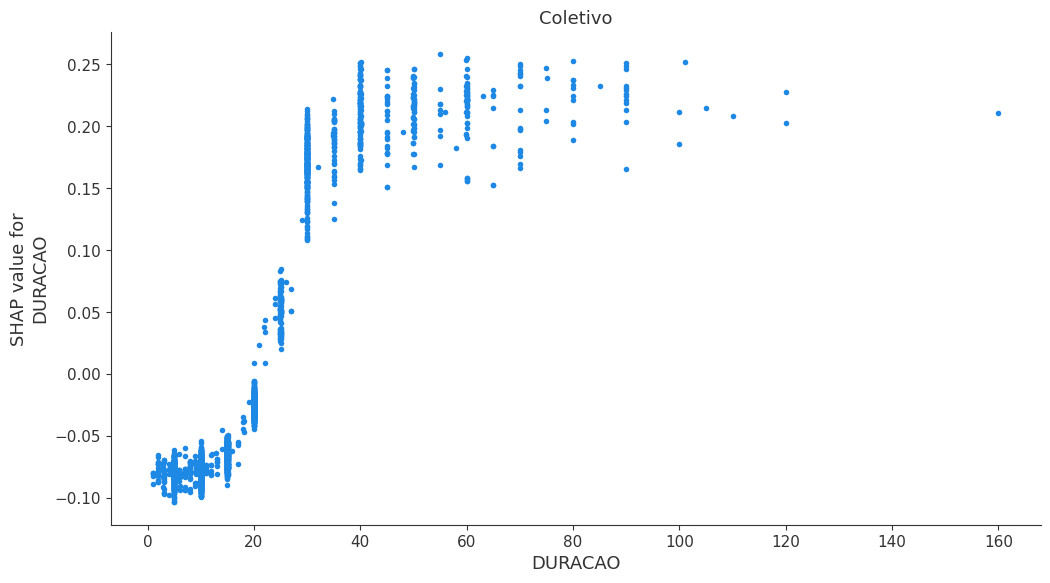

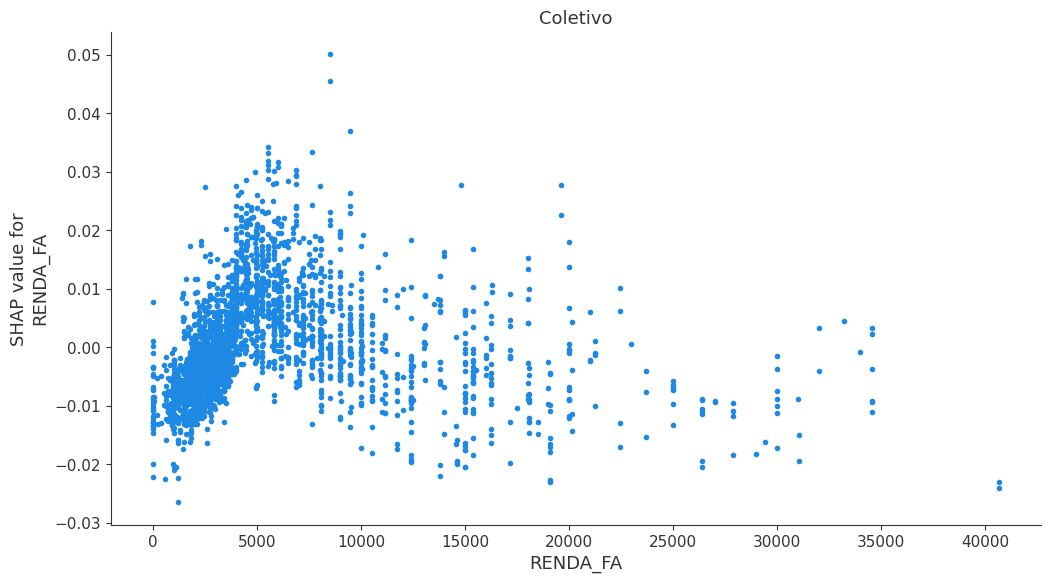

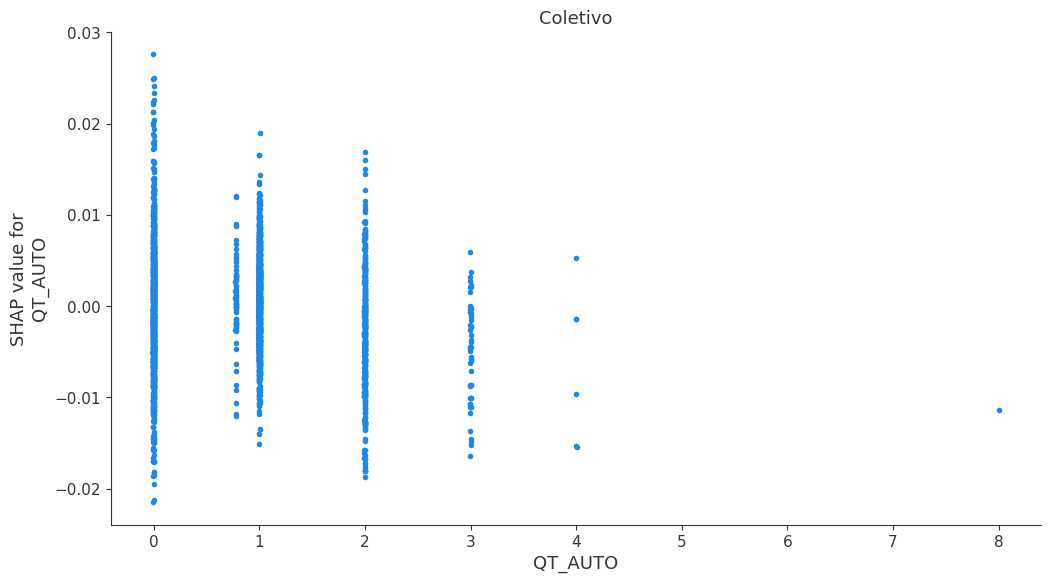

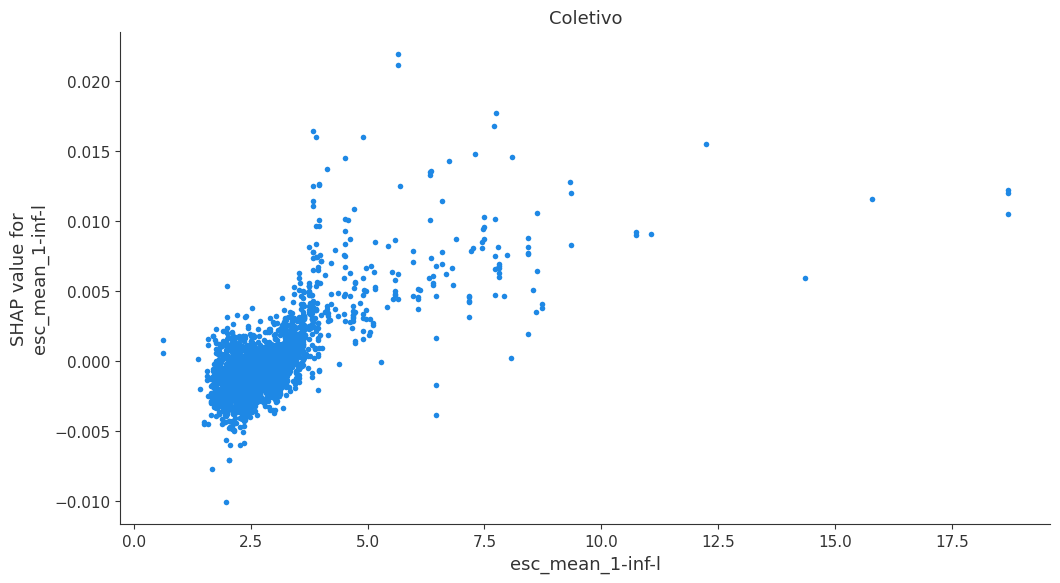

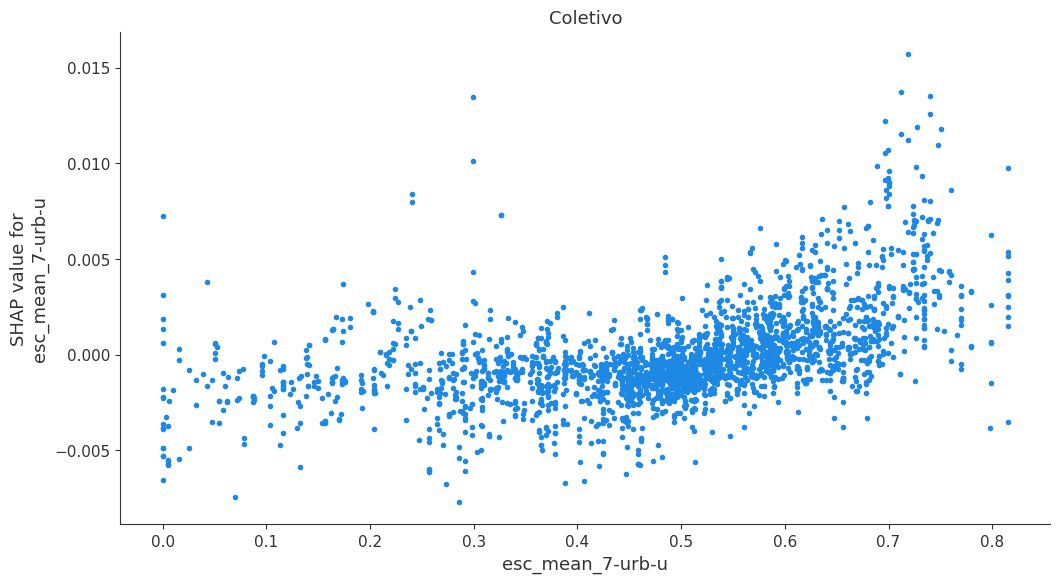

Individual


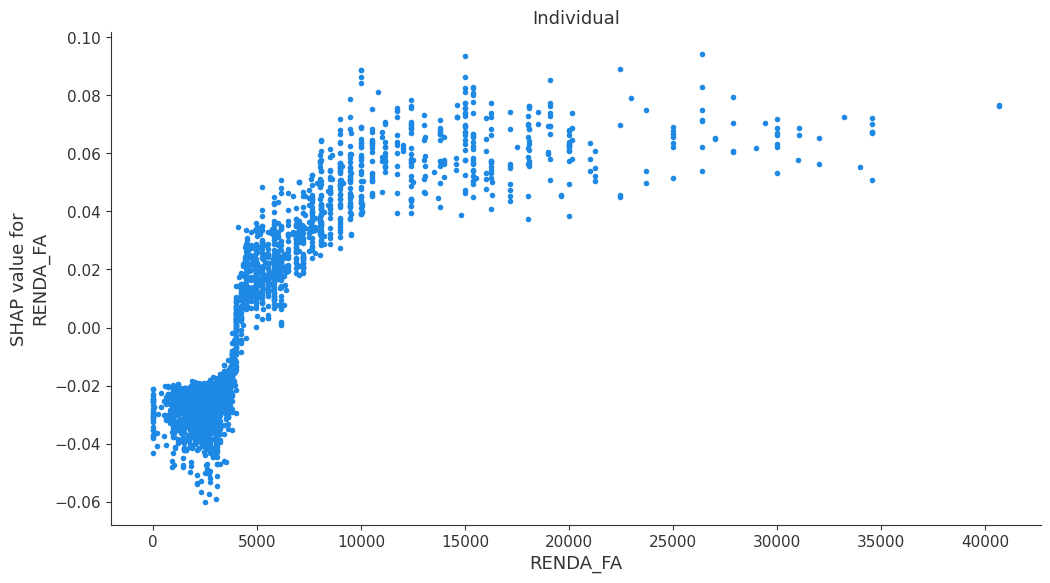

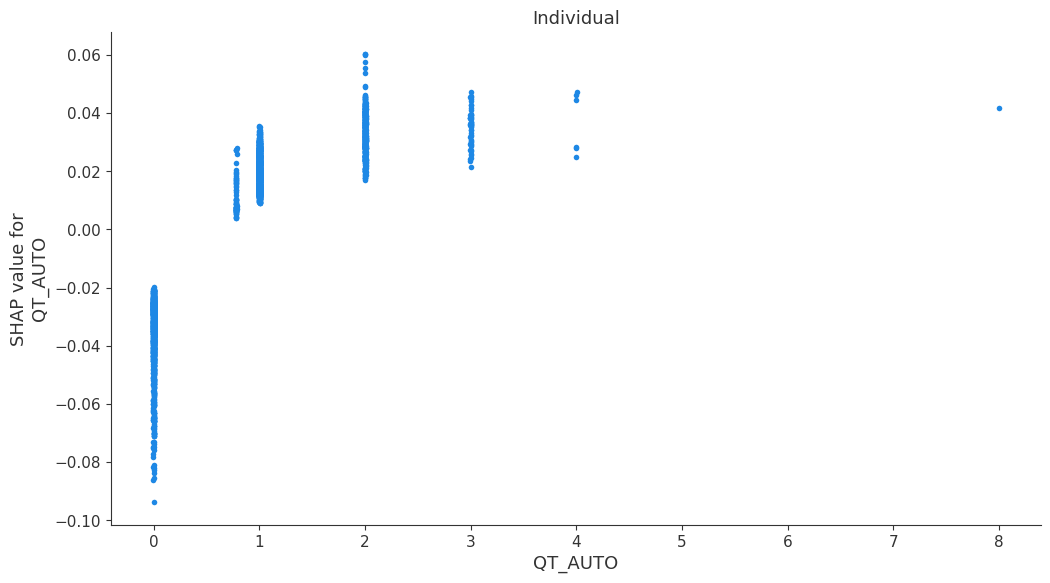

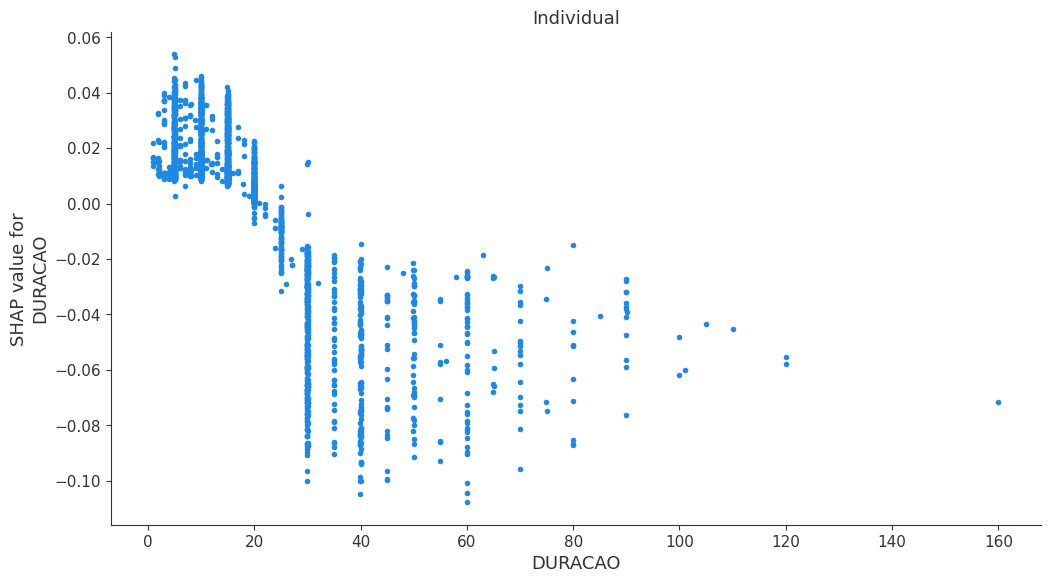

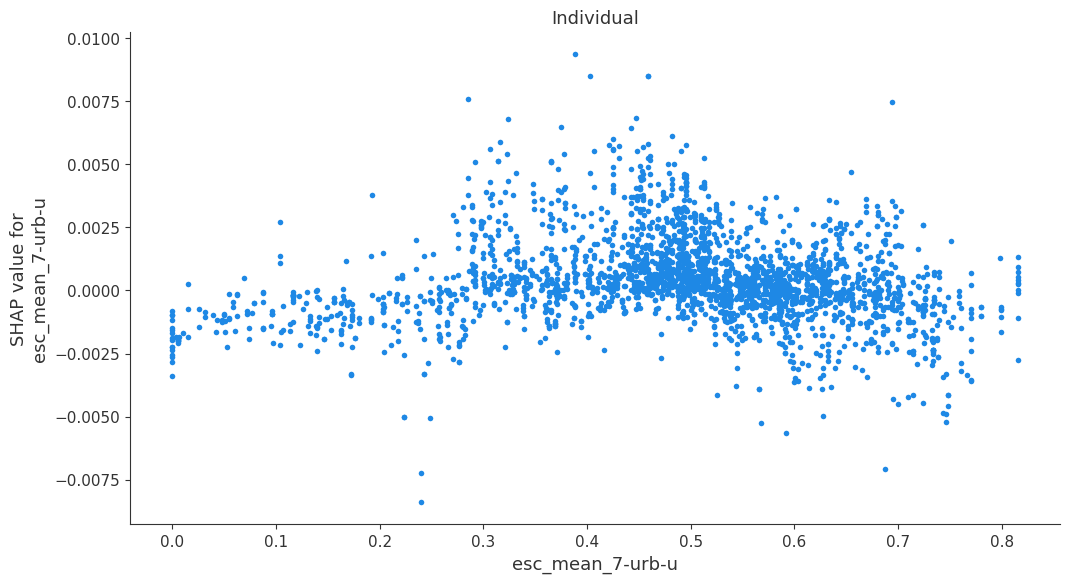

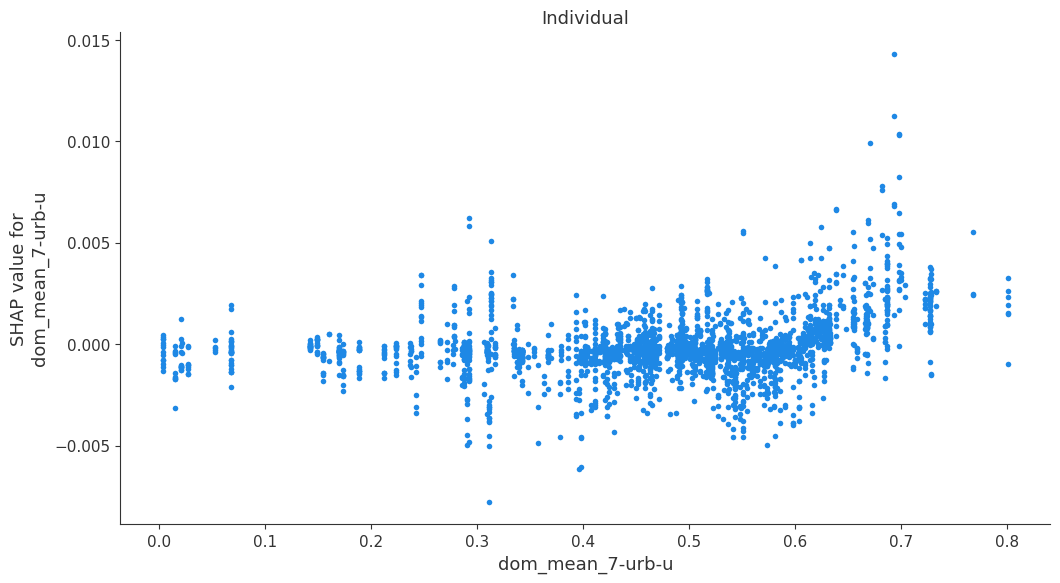

A pé


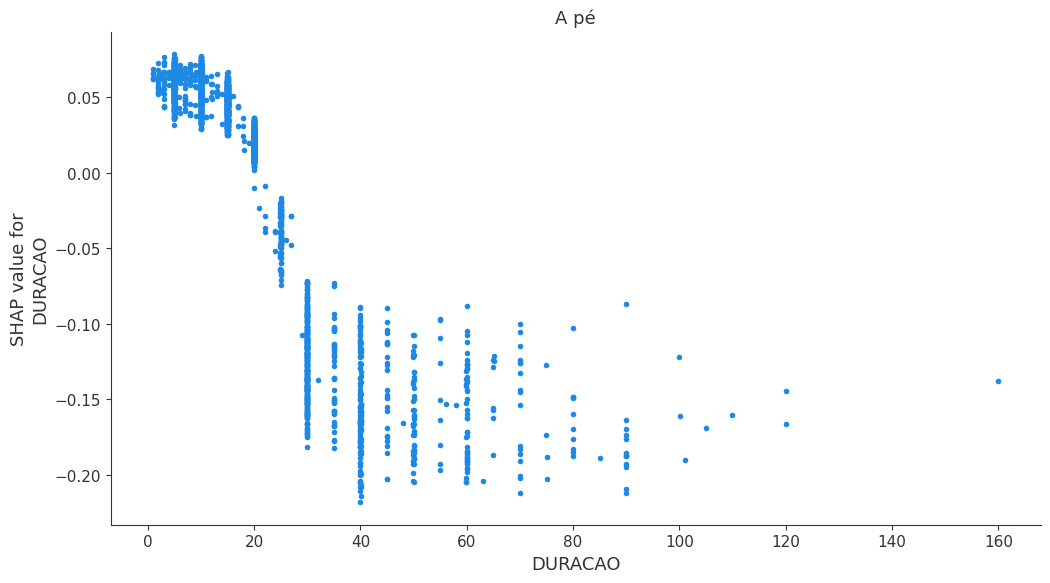

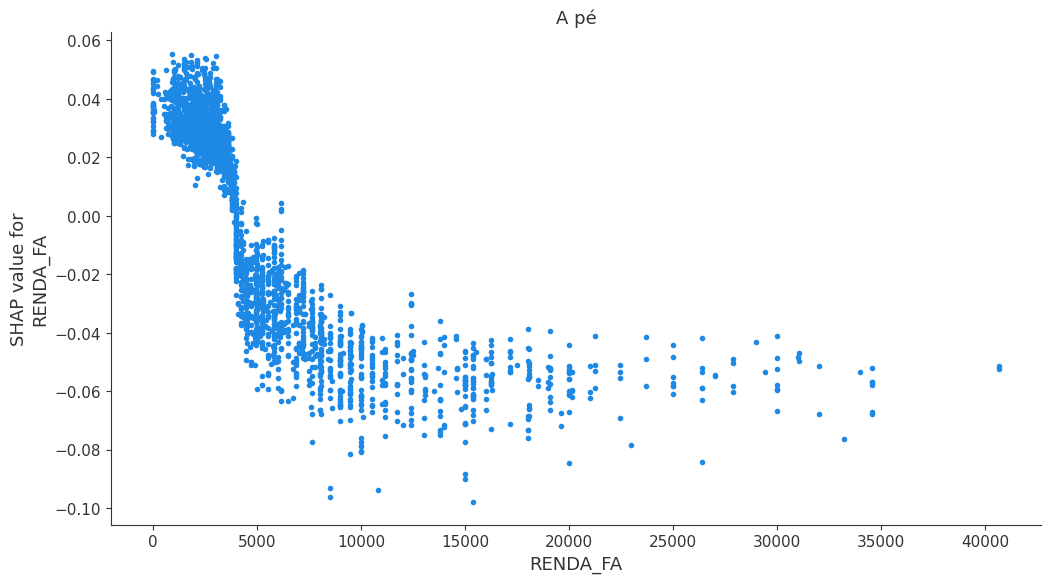

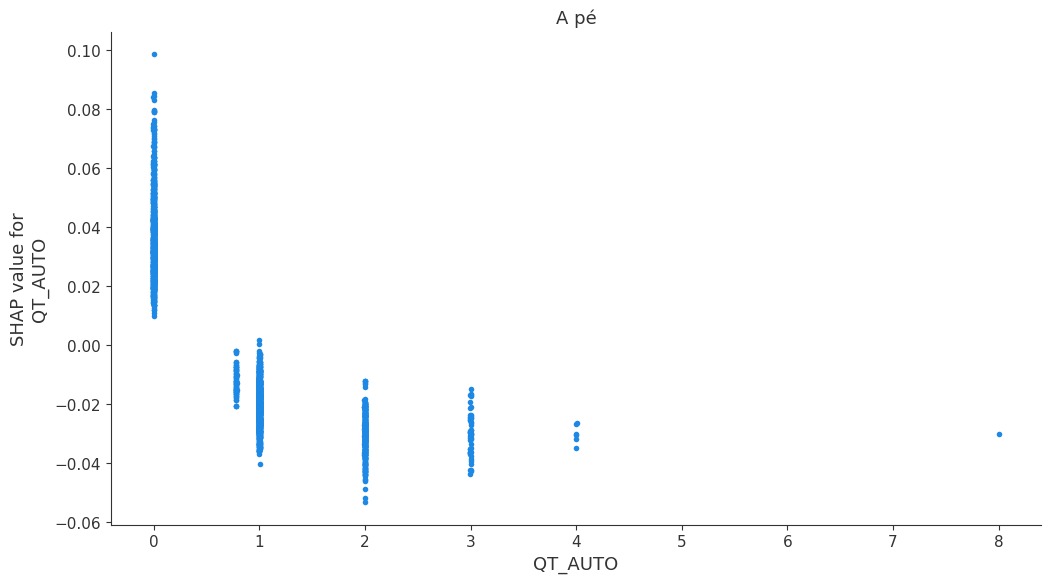

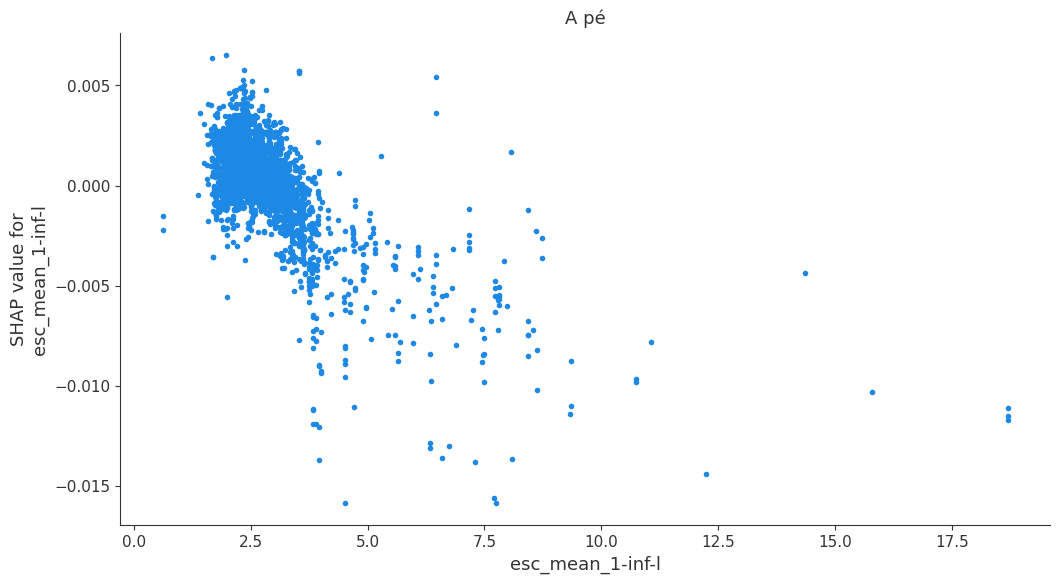

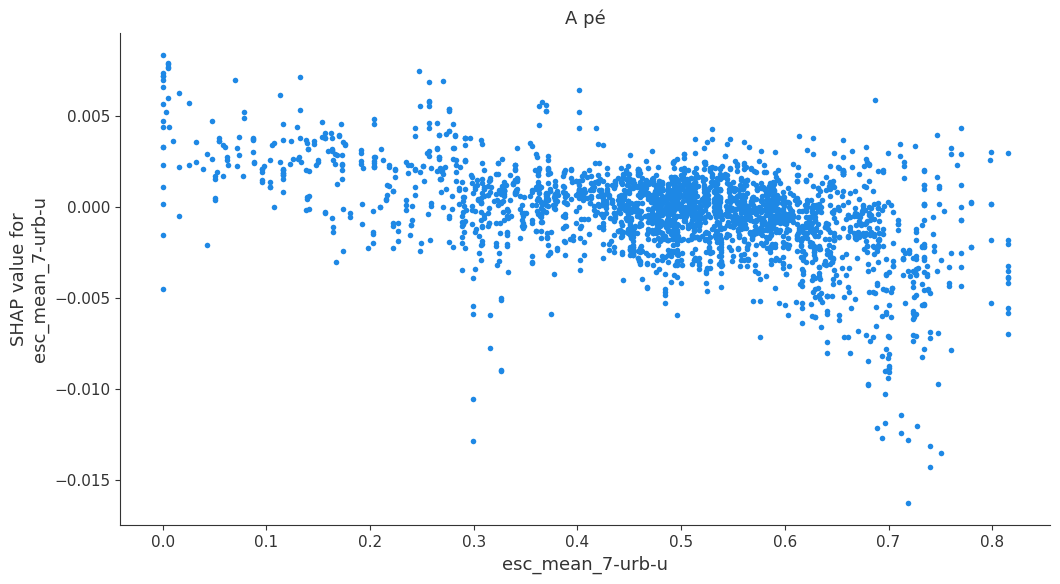

Bicicleta


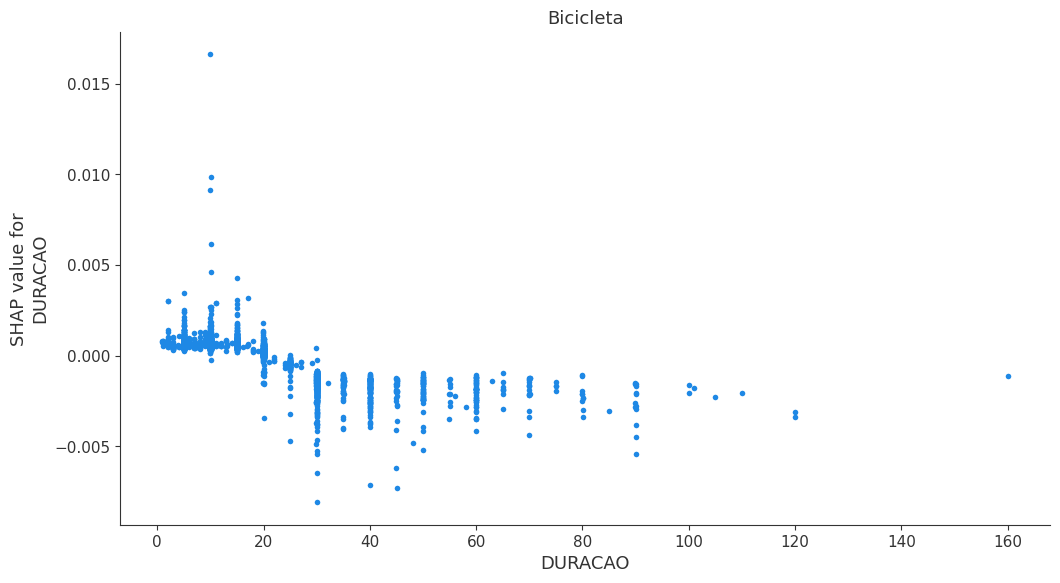

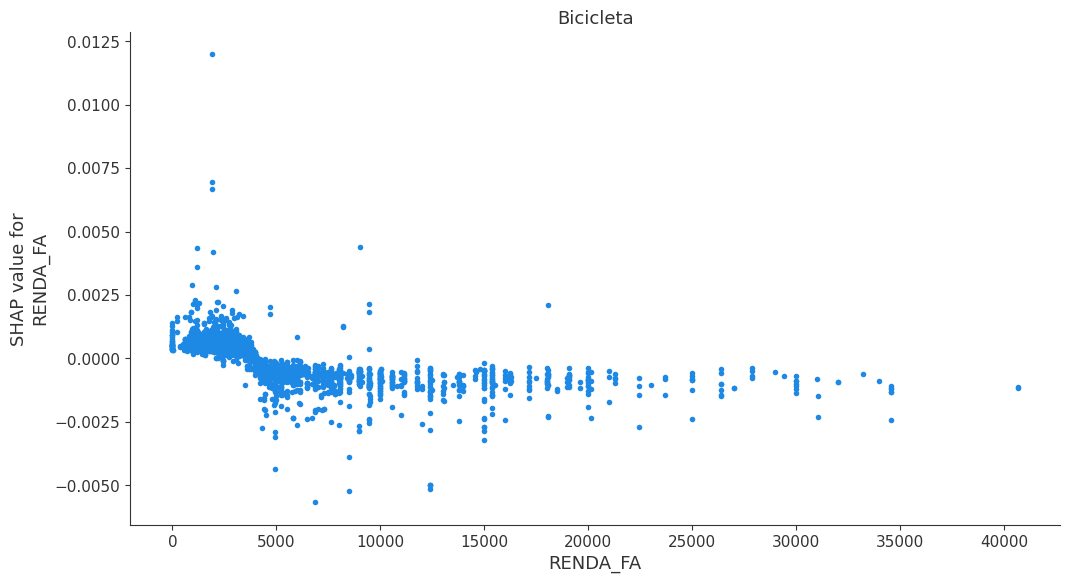

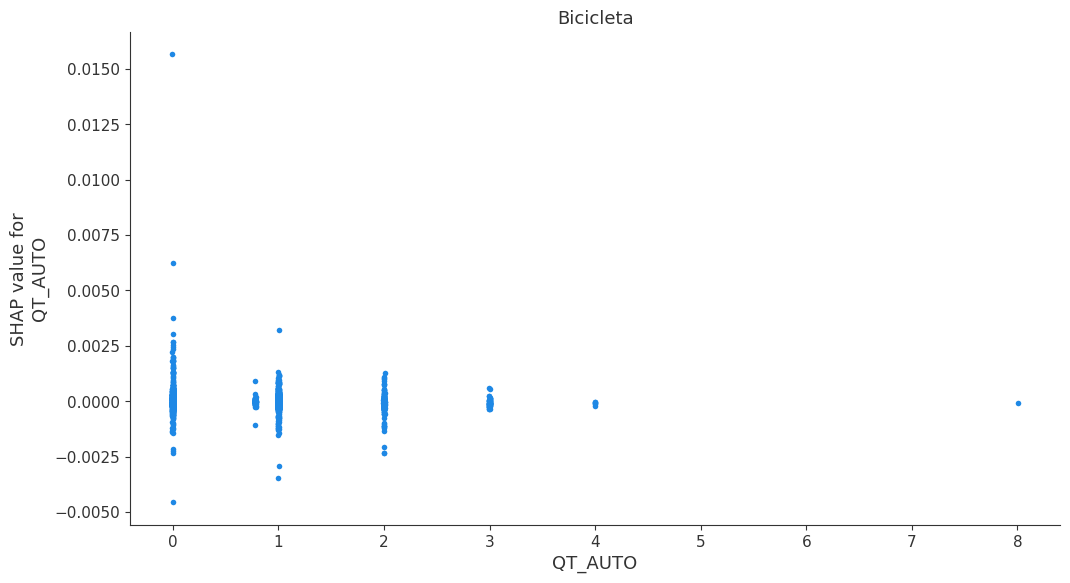

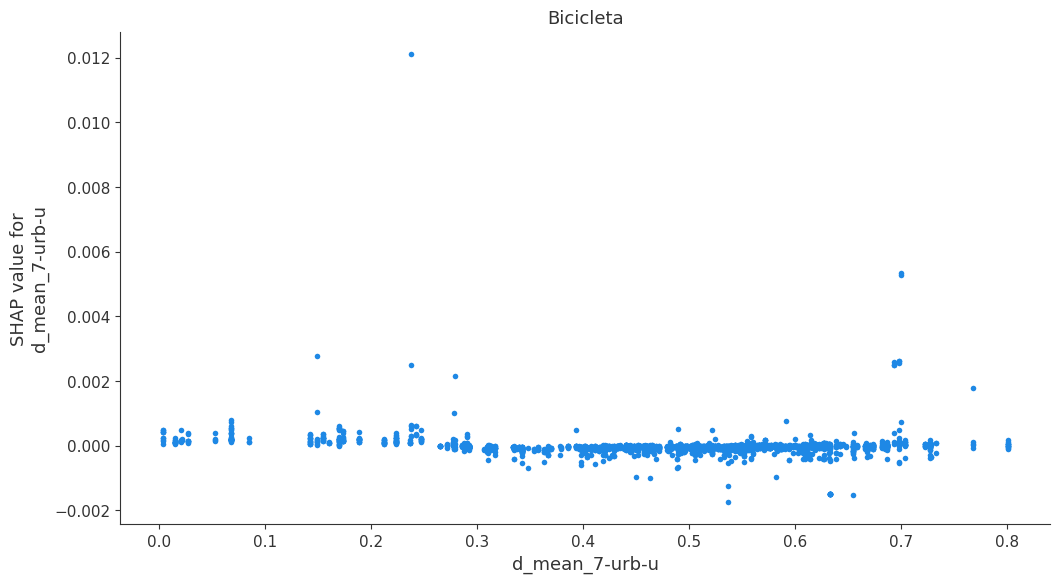

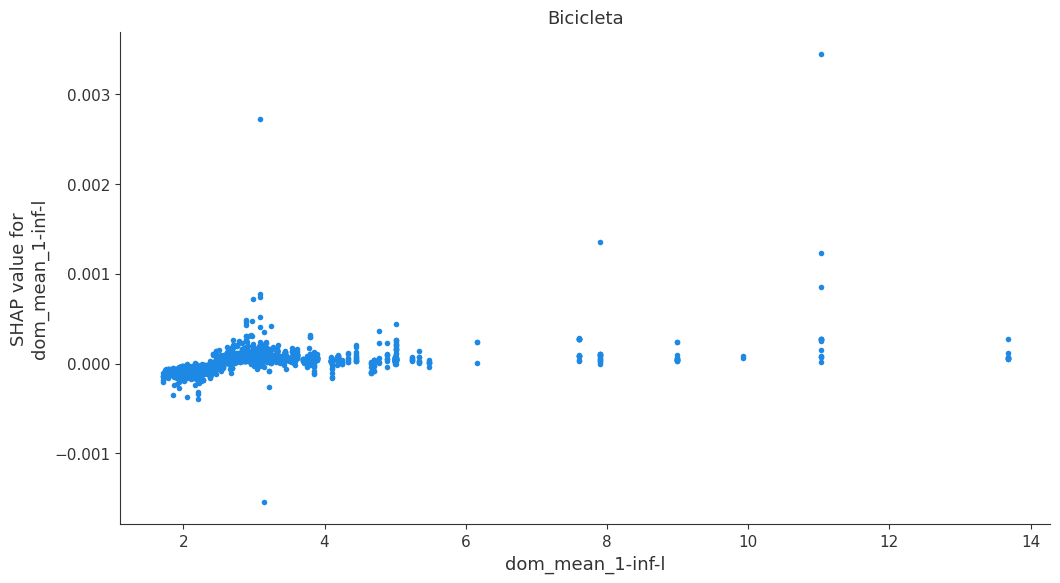

In [18]:
plot_scatter(df_barplot, shap_values_p, map_class_2)